In [18]:
import os
import git
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True

In [19]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")
main_df = main_df.copy()
np.random.seed(0)

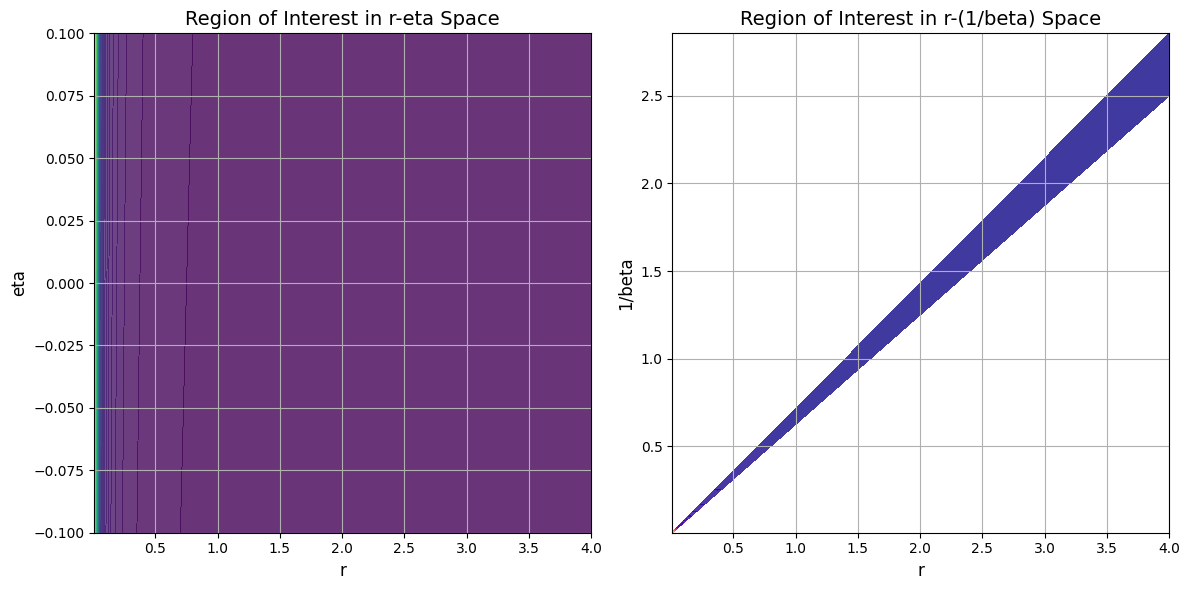

In [20]:
# Create meshgrid for the region of interest (ROI)
r_roi_mesh, eta_roi_mesh = np.meshgrid(r_shade_roi, eta_shade_roi)
beta_roi_mesh = (eta_roi_mesh + 1.5) / r_roi_mesh

# Plot the ROI in r-eta space and r-(1/beta) space side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot r-eta space
axes[0].contourf(r_roi_mesh, eta_roi_mesh, beta_roi_mesh, levels=100, cmap="viridis", alpha=0.8)
axes[0].set_title("Region of Interest in r-eta Space", fontsize=14)
axes[0].set_xlabel("r", fontsize=12)
axes[0].set_ylabel("eta", fontsize=12)
axes[0].grid(True)

# Plot r-(1/beta) space
axes[1].contourf(r_roi_mesh, 1 / beta_roi_mesh, beta_roi_mesh, levels=100, cmap="plasma", alpha=0.8)
axes[1].set_title("Region of Interest in r-(1/beta) Space", fontsize=14)
axes[1].set_xlabel("r", fontsize=12)
axes[1].set_ylabel("1/beta", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def plot_regions_with_roi(dataframes, title=""):
    """
    Plots the regions of the given dataframes alongside the region of interest (ROI).

    Parameters:
    - dataframes: list of pandas DataFrames, each containing a 'hull' column with convex hulls.
    """
    min_rs = [df['best_r'].min() for df in dataframes]
    max_rs = [df['best_r'].max() for df in dataframes]
    r_values = np.linspace(
        min(min_rs), 
        max(max_rs), 
        1000
    )

    min_etas = [df['best_eta'].min() for df in dataframes]
    max_etas = [df['best_eta'].max() for df in dataframes]
    eta_values = np.linspace(
        min([df['best_eta'].min() for df in dataframes]), 
        max([df['best_eta'].max() for df in dataframes]), 
        1000
    )

    r_mesh, eta_mesh = np.meshgrid(r_values, eta_values)

    fig, ax = plt.subplots(figsize=(10, 8))

    r_shade_roi = np.linspace(r_values.min(), r_values.max(), 100)
    eta_shade_roi = np.linspace(-0.1, 0.1, 100)

    r_roi_mesh, eta_roi_mesh = np.meshgrid(r_shade_roi, eta_shade_roi)
    beta_roi_mesh = (eta_roi_mesh + 1.5) / r_roi_mesh

    ax.contourf(r_roi_mesh, 1 / beta_roi_mesh, beta_roi_mesh, levels=100, colors='yellow', alpha=0.5)

    color_maps = ["Reds", "Blues", "Greens", "Purples", "Oranges"]
    names = []
    cntrs = []
    hs, ls = [], []
    # Plot regions for each dataframe
    for i, df in enumerate(dataframes):
        name = '-'.join(df[['dataset', 'subset']].iloc[0])
        names.append(name)
        score_matrix = np.zeros_like(r_mesh)
        for hull in df['hull'].dropna():
            path = scipy.spatial.Delaunay(hull.points).find_simplex(np.column_stack((r_mesh.ravel(), eta_mesh.ravel()))) >= 0
            score_matrix += path.reshape(r_mesh.shape)
        cntr = ax.contourf(r_mesh, eta_mesh, score_matrix, levels=100, cmap=color_maps[i % len(color_maps)], alpha=0.4, zorder=0)
        h,l = cntr.legend_elements("Z1")
        hs += h
        ls += l
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"Regions: {', '.join(names)}", fontsize=15)
    ax.set_xlabel("r", fontsize=12)
    ax.set_ylabel("1/beta", fontsize=12)
    ax.grid(True)
    ax.set_xlim((np.min(min_rs), np.mean(max_rs)))
    ax.set_ylim((-0.1, 3)) # np.min(min_etas) np.max(max_etas)
    hs = [plt.Line2D([0], [0], color=color_maps[i % len(color_maps)][:-1].lower(), lw=4) for i in range(len(names))]
    ax.legend(hs, names)
    plt.show()

    return fig


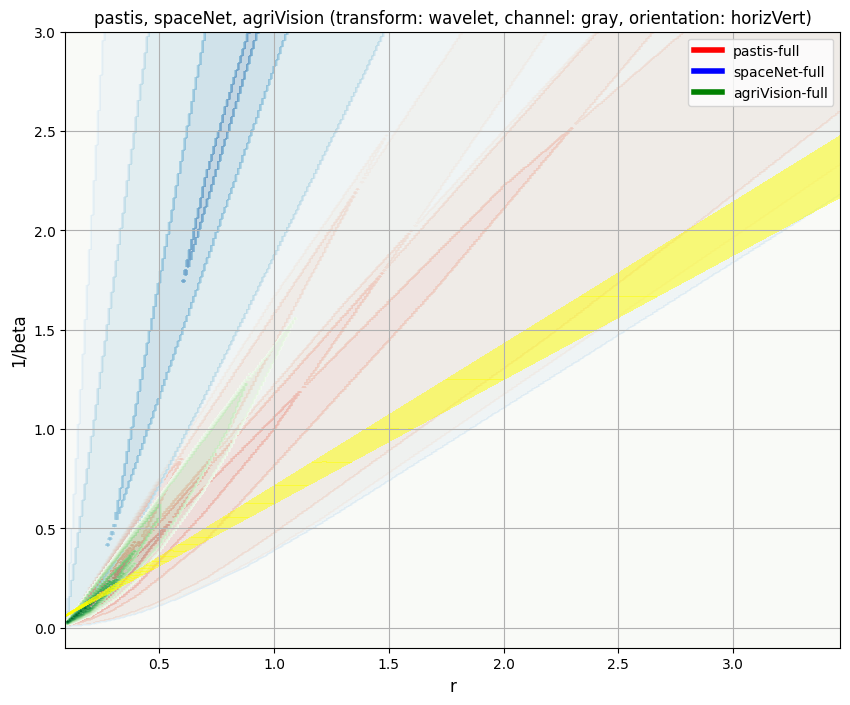

In [ ]:
transform, channel, orientation = 'wavelet', 'gray', 'horizVert'
broad_filter = (main_df['transform'] == transform) & (main_df['channel'] == channel) & (main_df['orientation'] == orientation)

temp = main_df[broad_filter].copy()

df1 = temp[(temp['dataset'] == 'pastis')]
df2 = temp[(temp['dataset'] == 'spaceNet')]
df3 = temp[(temp['dataset'] == 'agriVision')]

dataframes = [df1, df2, df3]
names = ['-'.join(df[['dataset']].iloc[0]) for df in dataframes]
title = ', '.join(names) + f' (transform: {transform}, channel: {channel}, orientation: {orientation})'
plot_regions_with_roi(dataframes, title)

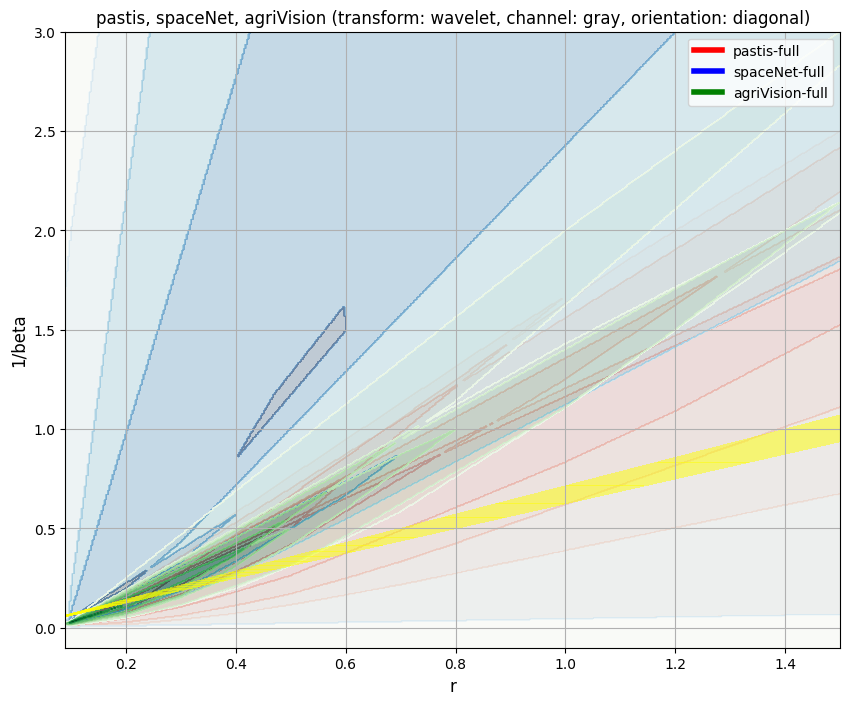

In [66]:
transform, channel, orientation = 'wavelet', 'gray', 'diagonal'
broad_filter = (main_df['transform'] == transform) & (main_df['channel'] == channel) & (main_df['orientation'] == orientation)

temp = main_df[broad_filter].copy()

df1 = temp[(temp['dataset'] == 'pastis')]
df2 = temp[(temp['dataset'] == 'spaceNet')]
df3 = temp[(temp['dataset'] == 'agriVision')]

dataframes = [df1, df2, df3]
names = ['-'.join(df[['dataset']].iloc[0]) for df in dataframes]
title = ', '.join(names) + f' (transform: {transform}, channel: {channel}, orientation: {orientation})'
plot_regions_with_roi(dataframes, title)

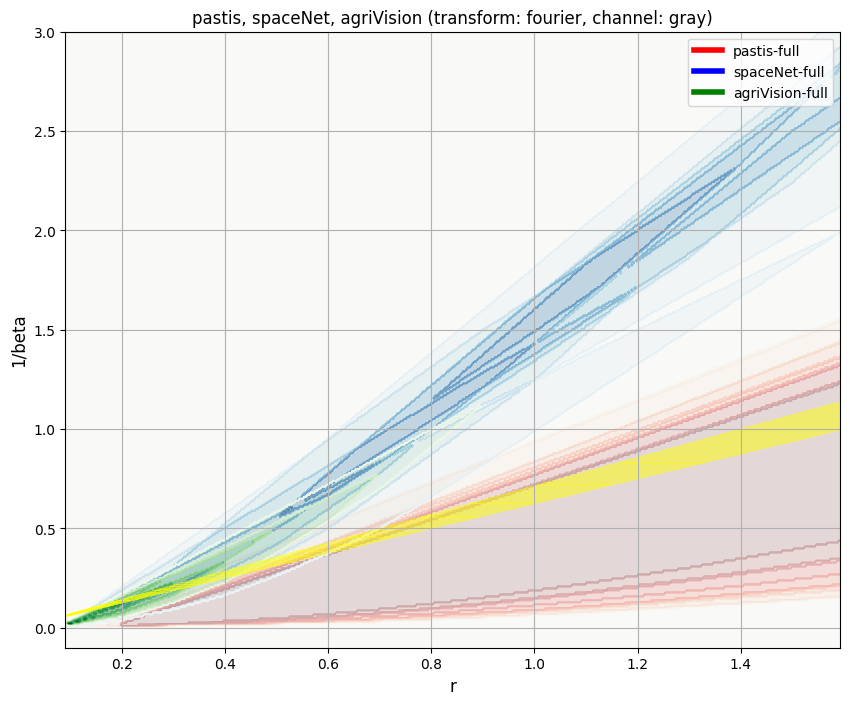

In [63]:
broad_filter = (main_df['transform'] == 'fourier') & (main_df['channel'] == 'gray')

temp = main_df[broad_filter].copy()

df1 = temp[(temp['dataset'] == 'pastis')]
df2 = temp[(temp['dataset'] == 'spaceNet')]
df3 = temp[(temp['dataset'] == 'agriVision')]

dataframes = [df1, df2, df3]
names = ['-'.join(df[['dataset']].iloc[0]) for df in dataframes]
title = ', '.join(names) + ' (transform: fourier, channel: gray)'
plot_regions_with_roi(dataframes, title)

In [70]:
temp

,group,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,...,github_plot,dataset_type,hull,best_beta,best_1/beta,beat_all_priors,best_prior,failure_category,failure_type,which_ones
113,2,49450.980000,19202.867000,101513.000000,500.580800,93.005810,851.761050,4500.0,0.3,-0.3,...,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,3.966667,0.252101,1,GenGamma,actually_pass,pass,NaN
114,3,8568.368000,4678.516000,14358.227000,487.672520,163.083920,789.382900,18000.0,0.1,1.9,...,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,42.222222,0.023684,1,GenGamma,practically_pass,pass,NaN
115,4,1787.585200,838.502750,3350.636500,762.550350,170.148350,1375.016500,72000.0,0.1,2.1,...,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,36.000000,0.027778,1,GenGamma,practically_pass,pass,NaN
116,5,284.274750,138.199070,671.343440,1228.929700,86.793030,3410.601800,288000.0,0.1,3.0,...,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,46.000000,0.021739,1,GenGamma,practically_pass,pass,NaN
117,6,70.411040,35.697952,185.533100,1638.797100,65.571650,3892.750500,1152000.0,0.1,3.8,...,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,53.000000,0.018868,1,GenGamma,practically_pass,pass,NaN
118,7,23.222046,12.280906,72.200690,2538.970500,51.936737,4483.448000,4608000.0,0.1,3.6,...,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,61.111111,0.016364,1,GenGamma,practically_pass,pass,NaN
119,8,9.512077,4.864893,27.376392,1990.125600,68.890760,4263.745600,18432000.0,0.1,3.0,...,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,44.000000,0.022727,1,GenGamma,practically_pass,pass,NaN
120,9,1.696372,0.967391,4.156639,1298.781500,67.881310,3193.164800,73728000.0,0.1,2.4,...,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,38.000000,0.026316,1,GenGamma,practically_pass,pass,NaN
121,10,0.181317,0.080193,0.812861,5574.856400,78.470020,6336.023000,294912000.0,0.1,1.7,...,https://github.com/yashdave003/hierarchical-ba...,remote sensing,<scipy.spatial._qhull.ConvexHull object at 0x0...,38.888889,0.025714,1,GenGamma,practically_pass,pass,NaN
246,2,1620.265600,1466.841600,1779.921800,0.232590,-0.116969,0.627984,1604.0,9.9,0.1,...,https://github.com/yashdave003/hierarchical-ba...,natural,<scipy.spatial._qhull.ConvexHull object at 0x0...,0.161616,6.187500,1,GenGamma,actually_pass,pass,NaN


In [67]:
# Define variables to control the slicing parameters
slice_start_row = -100
slice_end_row = -130
slice_start_col = 0
slice_end_col = 100

# Apply slicing using the defined variables
score_matrix_agriVision_flipped = np.flipud(score_matrix_agriVision)[slice_start_row:slice_end_row, slice_start_col:slice_end_col]
score_matrix_spacenet_flipped = np.flipud(score_matrix_spacenet)[slice_start_row:slice_end_row, slice_start_col:slice_end_col]
score_matrix_pastis_flipped = np.flipud(score_matrix_pastis)[slice_start_row:slice_end_row, slice_start_col:slice_end_col]

# Plot the heatmaps
plt.figure(figsize=(15, 10))
# sns.heatmap(score_matrix_pastis_flipped, alpha=0.3, cbar=False, cmap="Greens")
sns.heatmap(score_matrix_spacenet_flipped, alpha=1, cbar=False, cmap="Reds")
sns.heatmap(score_matrix_pastis_flipped, alpha=1, cbar=False, cmap="Blues")  # , cmap="Greens")
  # 
# sns.heatmap(score_matrix_spacenet_flipped, alpha=0.3, cbar=False)  # 


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1500x1000 with 0 Axes>